# <center> RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
*  Численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* Туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* Игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
Игрок может совершать одно из двух действий:
    1. Hit  — взять ещё одну карту;
    2. Stand — не брать больше карт;
* Если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* Если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* После этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* В исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [1]:
import itertools
from tqdm import tqdm
from collections import defaultdict
from tqdm.contrib.itertools import product

import gym
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from blackjack import BlackjackEnv

In [2]:
def simple_policy(observation):
    cards = observation[0]
    usable_ace = observation[2]
    if 18 < cards <= 21:
        return False # Stand
    return True # Hit

In [3]:
def generate_episode(env, policy):

    episode = []
    observation = env.reset()
    
    while True:
        action = policy(observation)
        next_observation, reward, done, info = env.step(action)
        episode.append((observation, reward, action))
        observation = next_observation
        if done:
            break
            
    return episode

In [4]:
class PlayBlackJack:
    
    def __init__(self, env):
        self.env = env
        
    def play_part(self, n, stategy):
        self.reward = []
        for _ in tqdm(range(n)):
            observation, reward, done = generate_episode(self.env, stategy)[-1]
            self.reward.append(reward)

In [5]:
env = BlackjackEnv(natural=True)
classic_blackjack = PlayBlackJack(env)

In [6]:
classic_blackjack.play_part(100000, simple_policy)

100%|██████████| 100000/100000 [00:05<00:00, 17964.12it/s]


In [7]:
print("Средний выигрыш при просто стратегии: {}".format(np.mean(classic_blackjack.reward)))

Средний выигрыш при просто стратегии: -0.18054


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [8]:
def get_probs(Q_state, epsilon, nA):

    probs = np.ones(nA) * (epsilon/nA)

    greedy_action = np.argmax(Q_state)
    probs[greedy_action] = 1 - epsilon + (epsilon/nA)
    
    return probs

In [9]:
def epsilon_greedy_policy(env, state, Q, epsilon):
    if state in Q: 
        return np.random.choice((0, 1), p=get_probs(Q[state], epsilon, env.action_space.n))
    else:
        return env.action_space.sample()

In [10]:
def generate_episode(env, policy, Q, epsilon):
    
    observations = []
    actions = []
    rewards = []
    observation = env.reset()
    
    while True:
        action = policy(env, observation, Q, epsilon)
        next_observation, reward, done, _ = env.step(action)

        observations.append(observation)
        actions.append(action)
        rewards.append(reward)
        observation = next_observation

        if done:
            break

    return observations, actions, rewards

In [11]:
def update_Q(env, Q, policy, gamma, epsilon, weights):
    
    states, actions, rewards = generate_episode(env, policy, Q, epsilon)

    G, W = 0, 1
    
    prob_best_action = 1 - (env.action_space.n - 1) * epsilon / env.action_space.n

    for i in range(len(rewards))[::-1]:
        state = states[i]
        action = actions[i]
        reward = rewards[i]

        G = gamma * G + reward
        weights[(state, action)] += W
        Q[state][action] += (G - Q[state][action]) * W / weights[(state, action)]
        
        a_star = np.argmax(Q[state])
        if a_star != action:
            break

        W = W / prob_best_action
        
    return Q    

In [12]:
def testing(env, Q, n=1000, tqdm_disable=True):
    
    rewards = []
    
    for _ in tqdm(range(n), disable=tqdm_disable):
        state = env.reset()
        while True:
            action = Q[state].argmax()
            state, reward, done, _ = env.step(action)
            if done:
                rewards.append(reward)
                break
                
    return np.mean(rewards)

In [13]:
def mc_control(
                env, 
                policy, 
                n, 
                test_freq, 
                gamma, 
                eps_start=1, 
                eps_decay=0.9999, 
                eps_min=0.05,
                tqdm_disable=True
):
    
    results = []

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    weights = defaultdict(lambda: 0)
    epsilon = eps_start

    for n in tqdm(range(n), disable=tqdm_disable):
        epsilon = max(epsilon * eps_decay, eps_min)
        Q = update_Q(env, Q, policy, gamma, epsilon, weights)

        if n % test_freq == 0:
            result = testing(env, Q)
            results.append(result)

    return results, Q

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [14]:
n = 100000
test_n = 10000
gammas = np.linspace(0.1, 1, 10)
eps_starts = np.linspace(0.2, 1, 5)

In [15]:
hyper_params = pd.DataFrame(columns=['gamma', 'eps_start', 'mean_reward'])
best_params, max_mean_reward = None, -float('inf')

for i, (gamma, eps_start) in enumerate(product(gammas, eps_starts)):
    rewards, Q = mc_control(
                            env,
                            epsilon_greedy_policy,
                            n,
                            test_n,
                            gamma,
                            eps_start,
                        )
    mean_reward = np.mean(rewards)
    hyper_params.loc[i] = (gamma, eps_start, mean_reward)

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
best_param_simple =  hyper_params.loc[hyper_params.mean_reward.argmax()]
best_param_simple

gamma          0.70000
eps_start      0.80000
mean_reward   -0.02215
Name: 33, dtype: float64

In [17]:
n = 2000000
test_n = 10000

In [18]:
result_simple = [mc_control(
                    env,
                    epsilon_greedy_policy,
                    n,
                    test_n,
                    best_param_simple['gamma'],
                    best_param_simple['eps_start'],
                    tqdm_disable=False
                    ) for _ in range(3)]

100%|██████████| 2000000/2000000 [03:20<00:00, 9974.74it/s] 


In [19]:
rewards_simple = np.mean([x[0] for x in result_simple], axis=0)
Q_simple = result_simple[0][1]

In [20]:
gamma_simple = round(best_param_simple['gamma'], 2)
eps_start_simple = round(best_param_simple['eps_start'], 2)
label_simple=f'gamma: {gamma_simple}, eps_start: {eps_start_simple}, mean_rewards: {np.mean(rewards_simple)}'

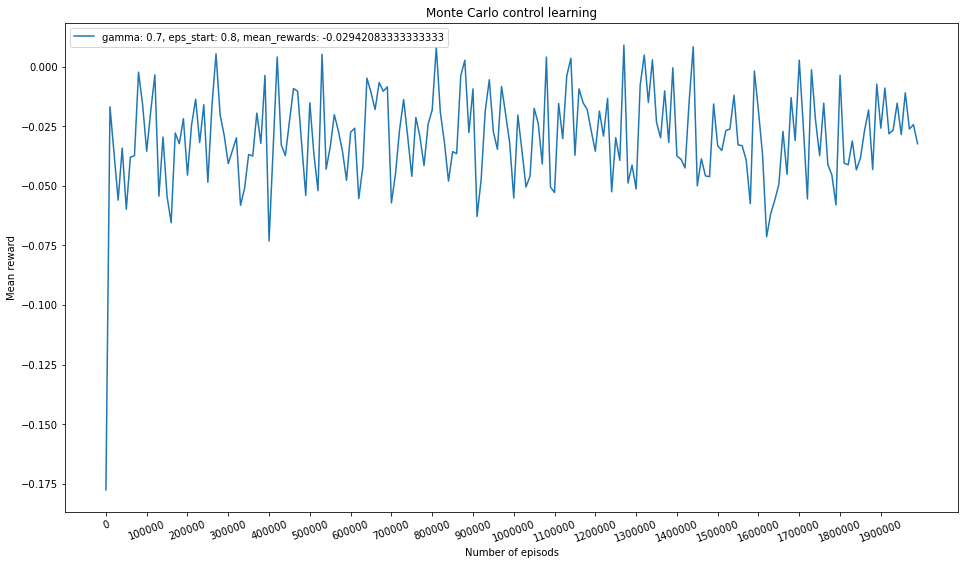

In [21]:
plt.figure(figsize=(16, 9))
plt.plot(list(range(0, n, test_n)), rewards_simple, label=label_simple)

plt.xlabel('Number of episods')
plt.ylabel('Mean reward')
plt.title('Monte Carlo control learning')

plt.xticks(list(range(0, n, test_n))[::10], list(range(0, n, test_n))[::10], rotation=20)
plt.legend()
plt.plot();

In [22]:
policy = dict((state, np.argmax(action)) for state, action in Q_simple.items())

In [23]:
from plot_utils import plot_policy

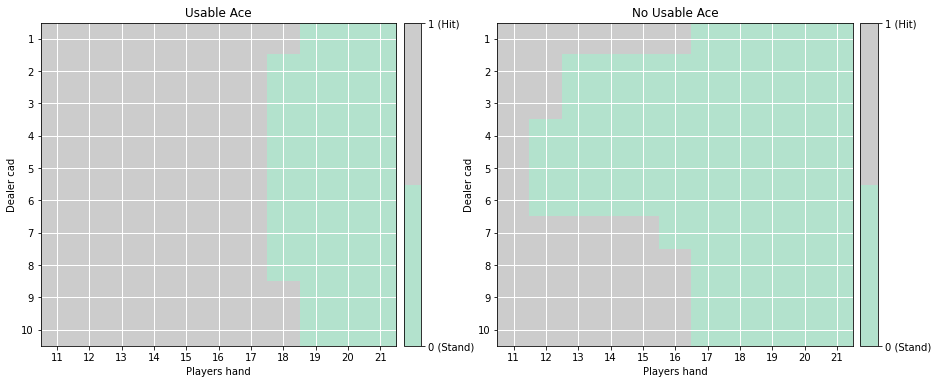

In [24]:
plot_policy(policy, 2)

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

1.) Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [25]:
from blackjack import DoubleBlackjackEnv

In [26]:
env_double = DoubleBlackjackEnv(True)

In [27]:
def epsilon_greedy_policy_double(env, state, Q, epsilon):
    if state in Q: 
        return np.random.choice((0, 1, 2), p=get_probs(Q[state], epsilon, env.action_space.n))
    else:
        return env.action_space.sample()

2.) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [28]:
n = 100000
test_n = 10000
gammas = np.linspace(0.1, 1, 10)
eps_starts = np.linspace(0.2, 1, 5)

In [29]:
hyper_params_double = pd.DataFrame(columns=['gamma', 'eps_start', 'mean_reward'])
best_params, max_mean_reward = None, -float('inf')

for i, (gamma, eps_start) in enumerate(product(gammas, eps_starts)):
    rewards, Q = mc_control(
                            env_double,
                            epsilon_greedy_policy_double,
                            n,
                            test_n,
                            gamma,
                            eps_start,
                        )
    mean_reward = np.mean(rewards)
    hyper_params_double.loc[i] = (gamma, eps_start, mean_reward)

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
best_param_double =  hyper_params_double.loc[hyper_params_double.mean_reward.argmax()]
best_param_double

gamma          0.4000
eps_start      0.8000
mean_reward   -0.0229
Name: 18, dtype: float64

In [31]:
n = 2000000
test_n = 10000

In [32]:
results_double = [mc_control(
                    env_double,
                    epsilon_greedy_policy_double,
                    n,
                    test_n,
                    best_param_double['gamma'],
                    best_param_double['eps_start'],
                    tqdm_disable=False
                ) for _ in range(3)]

100%|██████████| 2000000/2000000 [03:18<00:00, 10064.68it/s]


In [33]:
rewards_double = np.mean([x[0] for x in results_double], axis=0)
Q_double = results_double[0][1]

In [34]:
best_param_double

gamma          0.4000
eps_start      0.8000
mean_reward   -0.0229
Name: 18, dtype: float64

In [35]:
gamma_double = round(best_param_double['gamma'], 2)
eps_start_double = round(best_param_double['eps_start'], 2)
label_double = f'gamma: {gamma_double}, eps_start: {eps_start_double}, mean_rewards: {np.mean(rewards_double)}'

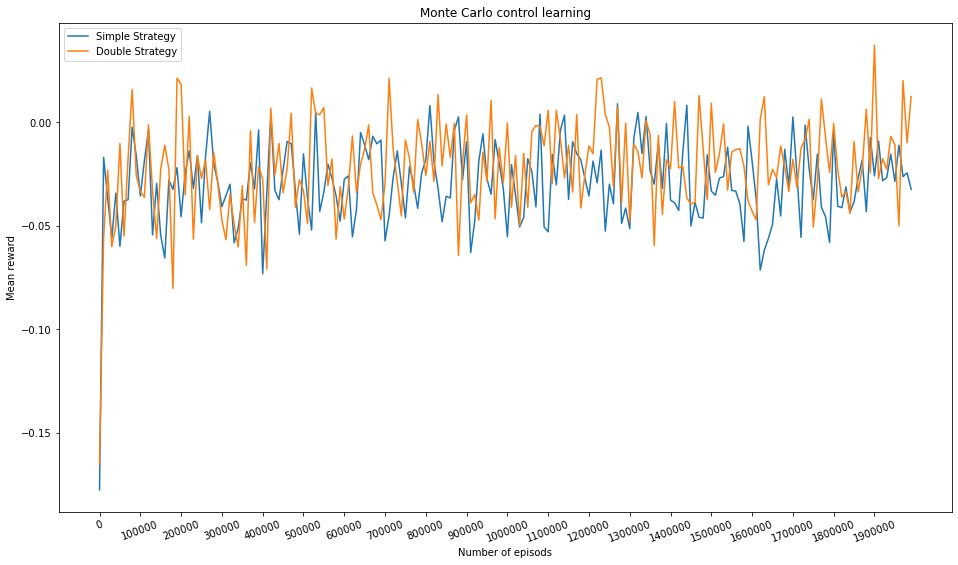

In [36]:
plt.figure(figsize=(16, 9))
plt.plot(list(range(0, n, test_n)), rewards_simple, label='Simple Strategy')
plt.plot(list(range(0, n, test_n)), rewards_double, label='Double Strategy')

plt.xlabel('Number of episods')
plt.ylabel('Mean reward')
plt.title('Monte Carlo control learning')

plt.xticks(list(range(0, n, test_n))[::10], list(range(0, n, test_n))[::10], rotation=20)
plt.legend()
plt.plot();

In [37]:
policy_double = dict((state, np.argmax(action)) for state, action in Q_double.items())
policy_simple = dict((state, np.argmax(action)) for state, action in Q_simple.items())

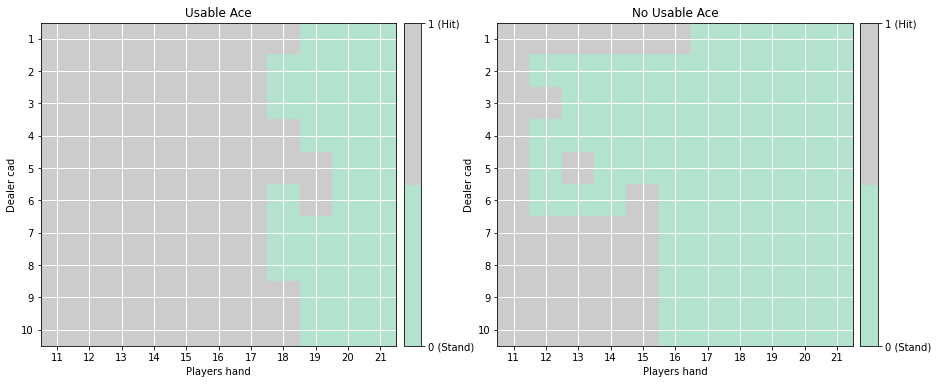

In [38]:
plot_policy(policy_double, 2)

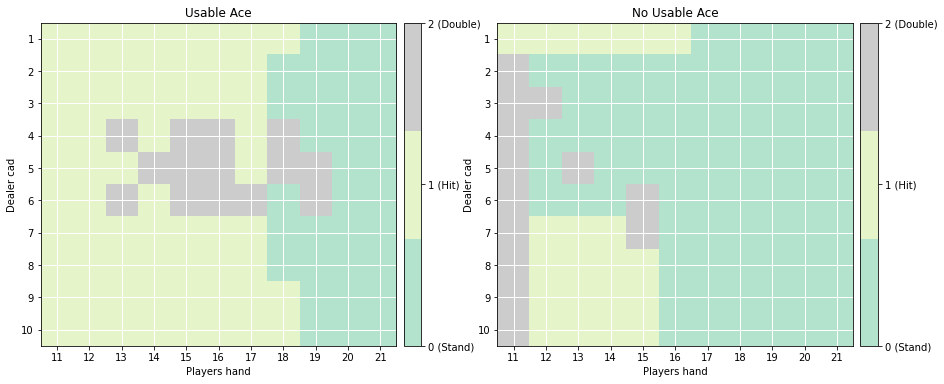

In [39]:
plot_policy(policy_double, 3)

# Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка: 

<img src='hoffman.png'>
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) о блекджеке (а возможно, и нет).

In [40]:
from blackjack import HoffmanBlackjackEnv

In [41]:
env_hoffman = HoffmanBlackjackEnv(True)

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [42]:
n = 1000000
test_n = 10000
gammas = np.linspace(0.1, 1, 10)
eps_starts = np.linspace(0.2, 1, 5)

In [43]:
hyper_params_hoffman = pd.DataFrame(columns=['gamma', 'eps_start', 'mean_reward'])
best_params, max_mean_reward = None, -float('inf')

for i, (gamma, eps_start) in enumerate(product(gammas, eps_starts)):
    rewards, Q = mc_control(
                            env_hoffman,
                            epsilon_greedy_policy_double,
                            n,
                            test_n,
                            gamma,
                            eps_start,
                        )
    mean_reward = np.mean(rewards)
    hyper_params_hoffman.loc[i] = (gamma, eps_start, mean_reward)

  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
best_param_hoffman =  hyper_params_hoffman.loc[hyper_params_hoffman.mean_reward.argmax()]
best_param_hoffman

gamma          0.40000
eps_start      0.40000
mean_reward   -0.04575
Name: 16, dtype: float64

In [45]:
n = 2000000
test_n = 10000

In [46]:
results_hoffman = [mc_control(
                    env_hoffman,
                    epsilon_greedy_policy_double,
                    n,
                    test_n,
                    best_param_hoffman['gamma'],
                    best_param_hoffman['eps_start'],
                    tqdm_disable=False
                ) for _ in range(3)]

100%|██████████| 2000000/2000000 [04:02<00:00, 8255.72it/s]


In [47]:
rewards_hoffman = np.mean([x[0] for x in results_hoffman], axis=0)
Q_hoffman = results_hoffman[0][1]

In [48]:
best_param_hoffman

gamma          0.40000
eps_start      0.40000
mean_reward   -0.04575
Name: 16, dtype: float64

In [49]:
gamma_hoffman = round(best_param_hoffman['gamma'], 2)
eps_start_hoffman = round(best_param_hoffman['eps_start'], 2)
label_hoffman = f'gamma: {gamma_hoffman}, eps_start: {eps_start_hoffman}, mean_rewards: {np.mean(rewards_hoffman)}'

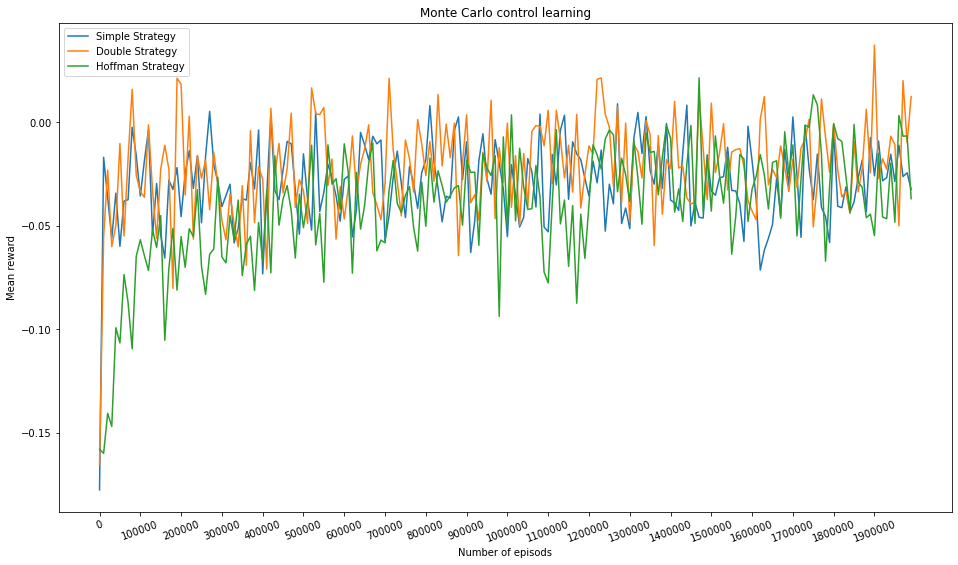

In [50]:
plt.figure(figsize=(16, 9))
plt.plot(list(range(0, n, test_n)), rewards_simple, label='Simple Strategy')
plt.plot(list(range(0, n, test_n)), rewards_double, label='Double Strategy')
plt.plot(list(range(0, n, test_n)), rewards_hoffman, label='Hoffman Strategy')

plt.xlabel('Number of episods')
plt.ylabel('Mean reward')
plt.title('Monte Carlo control learning')

plt.xticks(list(range(0, n, test_n))[::10], list(range(0, n, test_n))[::10], rotation=20)
plt.legend()
plt.plot();